## 3.3. pseudotime expression pattern response genes

In this notebook we will explore the expression patterns (=dynamics) of the response genes in pseudotime. We will take the top 500 response genes, which can be found using R script 2.1. Additionally, we use the pseudotemporal ordering of all cells in the dataset, which was found using R script 3.1. If you don't want to run those scripts you can also find the files on the Github repository (`results/response_genes_top500.csv` and `results/pseudotime/pseudotime_all_cells.csv`).

In this script we will cluster the response genes based on their dynamics in pseudotime. This will allow us to find clusters of response genes that have a similar expression pattern in time.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors #for making colormap
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering
from scipy.cluster import hierarchy #for hiearchical clustering
from scipy.spatial import distance #for hiearchical clustering

### Load data

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3) and the list of top 500 response genes.

In [2]:
### load Anndata object with the timeseries dataset
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [4]:
### load top 500 response genes
response_genes_path = "../results/response_genes/response_genes_top500.csv"
response_genes = pd.read_csv(response_genes_path)
response_genes = response_genes.values.flatten() #move genes from dataframe to array

In [5]:
### load pseudotime 
pseudotime_path = "../results/pseudotime/pseudotime_all_cells.csv"
pseudotime = pd.read_csv(pseudotime_path, sep=",", index_col=0)

In [6]:
### add pseudotime to dataset
adata.obs["pseudotime"] = pseudotime

In [7]:
### get timepoints and cell types
timepoints = adata.obs["time"].cat.categories.values
celltypes = adata.obs['clusters'].cat.categories.values

### Cluster response genes based on expression pattern
Each response gene in the list of response genes has an expression pattern in pseudotime. We can find this pattern by arranging the cells in their pseudotemporal order and taking the mean expression per 100 cells. We will scale the gene expression between 0 and 1 to be able to compare different response genes.

Below, we will also cluster response genes with similar expression patterns together.

In [8]:
### get expression of response genes
expression_genes = adata[:,response_genes].X.todense()
expression_genes = pd.DataFrame(expression_genes, columns=response_genes, index=adata.obs["pseudotime"])
expression_genes = expression_genes.sort_index()
expression_genes = expression_genes.T

In [9]:
### take mean expression per 100 cells
expression_genes = expression_genes.groupby(np.arange(len(expression_genes.columns))//100, axis=1).mean()

In [10]:
### scale expression between 0 and 1
expression_genes = expression_genes.sub(expression_genes.min(axis=1), axis=0).divide((expression_genes.max(axis=1) - expression_genes.min(axis=1)), axis=0)

In [11]:
### get linkage
row_linkage = hierarchy.linkage(distance.pdist(expression_genes), method='ward')

### get clusters
clusters = fcluster(row_linkage, t=5.9, criterion='distance')
clusters = pd.Series(clusters)

### add gene names to clusters
clusters.index = response_genes

In [12]:
len(np.unique(clusters))

16

### Plot expression pattern and response gene clusters

Here, we plot the expression of the response genes in pseudotime in a heatmap. The rows (genes) will be grouped by the clusters we defined above. For each cluster we will see the average pattern on the right side of the plot. 

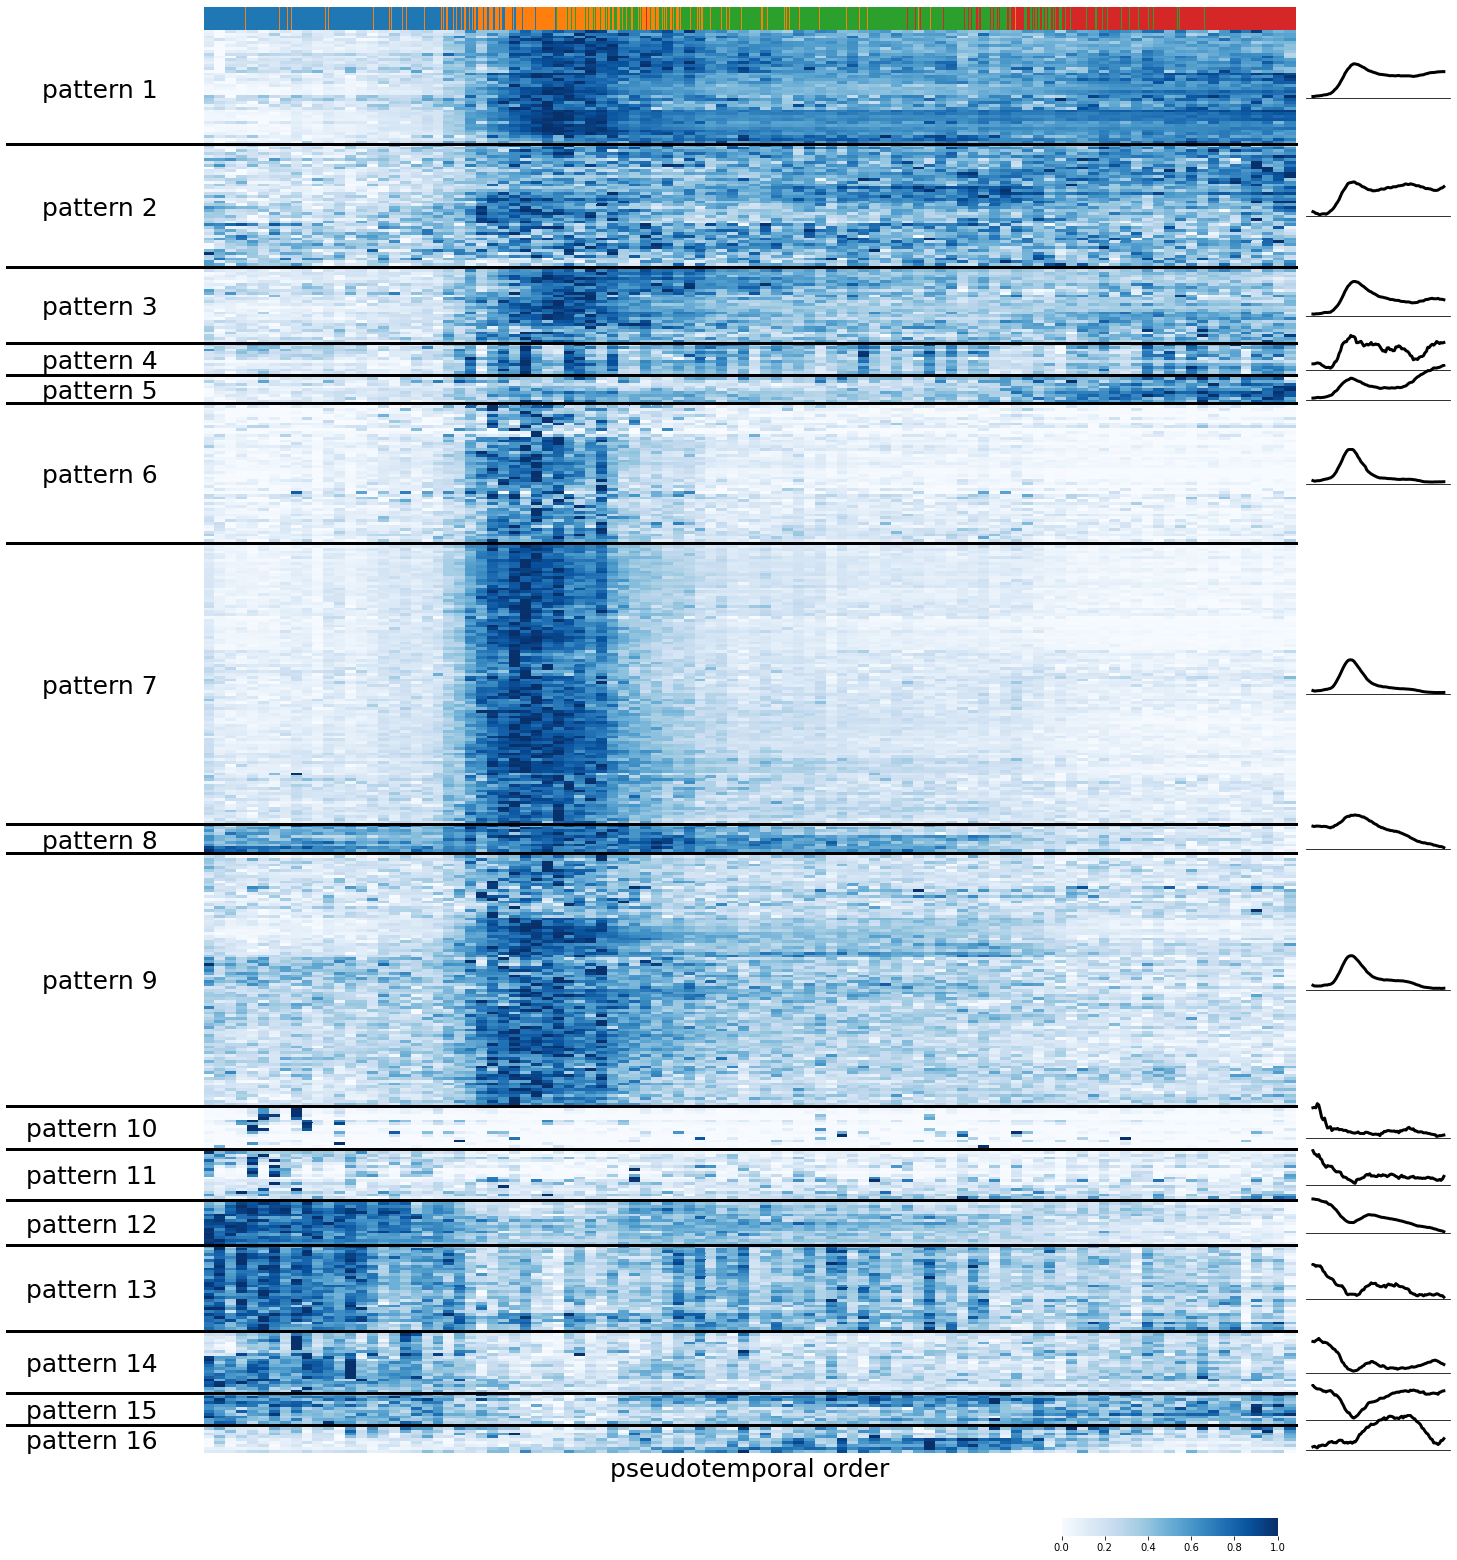

In [13]:
### add row colors so ax_row_colors is created
row_colors = ["#ffffff"]*len(clusters)

### create heatmap
fig = sns.clustermap(expression_genes.reset_index(drop=True), row_linkage=row_linkage, 
                     col_cluster=False, method="ward", figsize=(20, 25),
                     cmap="Blues",yticklabels=False,xticklabels=False,
                     cbar_kws={"orientation": "horizontal"}, row_colors=row_colors)

### change position of colorbar
fig.cax.set_position([0.83, -0.04, .15, .01])

### remove dendrogram
fig.ax_row_dendrogram.set_visible(False)

### add x axis label
fig.ax_heatmap.set_xlabel("pseudotemporal order", fontsize=25)

### add black lines
cluster_sizes = clusters.value_counts().sort_index()
size=0
for i in cluster_sizes.index[0:len(cluster_sizes)-1]:
    size+=cluster_sizes[i]
    fig.ax_heatmap.axhline(size,color='black',ls='-', xmin=-.18, xmax=1, clip_on = False, linewidth=3)

### add patterns on right side
size=0
bottom_heatmap = np.array(fig.ax_heatmap.get_position())[0][1]
top_heatmap = np.array(fig.ax_heatmap.get_position())[1][1]
total_length = top_heatmap-bottom_heatmap
length_per_gene = total_length/len(response_genes)    
for i in cluster_sizes.index:
    size+=cluster_sizes[i]
    position=top_heatmap-(size*length_per_gene)-bottom_heatmap+(cluster_sizes[i]/2*length_per_gene)
    axs2 = fig.fig.add_axes([1,position,0.1,0.02])
    #axs2.plot(expression_genes.loc[response_genes[clusters==i]].mean(axis=0).rolling(10).sum(), linewidth=3, color=lut[np.unique(clusters)[i-1]])
    axs2.plot(expression_genes.loc[response_genes[clusters==i]].mean(axis=0).rolling(10, center=True).mean(), linewidth=3, color="black")
    axs2.spines['top'].set_visible(False)
    axs2.spines['right'].set_visible(False)
    axs2.spines['left'].set_visible(False)
    axs2.get_xaxis().set_ticks([])
    axs2.get_yaxis().set_ticks([])
    axs2.patch.set_alpha(0)
    #axs2.axis('off')
    
### add pattern number to each cluster
net_ind = (cluster_sizes.cumsum()-(cluster_sizes/2))
net_names = ["pattern " + str(i) for i in range(1, len(cluster_sizes)+1)]
#net_names[9] = ""
#net_names[12] = ""
#net_names[16] = ""
fig.ax_row_colors.set_yticks(net_ind)
fig.ax_row_colors.set_yticklabels(net_names, fontdict=dict(color="black",size=25))
fig.ax_row_colors.yaxis.set_tick_params(size=0)

### add bar for distribution of experimental time
code=pd.factorize(adata.obs["time"][adata.obs["pseudotime"].sort_values().index])[0]
time_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cmap = colors.ListedColormap(time_colors)
fig.ax_col_dendrogram.imshow(code.reshape(1, -1), 
                             cmap=cmap, aspect='auto',
                             interpolation='nearest')

### decrease size of ax above the heatmap
hm = fig.ax_col_dendrogram.get_position()
fig.ax_col_dendrogram.set_position([hm.x0, hm.y0, hm.width, hm.height/15])


### save figure
save_path = "../figures/3.3.heatmap_patterns_response_genes.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
    
plt.show()

### Save response genes in each pattern
Lastly, we will save which response genes are assigned to each pattern in a .csv file for further downstream analyses (such as GO terms).

In [14]:
### make dataframe with response genes per pattern in columns
clustered_genes = [clusters[clusters == i].index.values for i in range(1, clusters.max()+1)]
clustered_genes = pd.DataFrame(clustered_genes, index=range(1, clusters.max()+1), columns=None).T
clustered_genes.columns = ['pattern' + str(i) for i in clustered_genes.columns.values]
clustered_genes = clustered_genes.fillna(value=np.nan)
clustered_genes

,pattern1,pattern2,pattern3,pattern4,pattern5,pattern6,pattern7,pattern8,pattern9,pattern10,pattern11,pattern12,pattern13,pattern14,pattern15,pattern16
0,Rpl35,H2-Q7,Rps28,Hist1h2ap,Gm10020,Mnda,Isg15,Plac8,Ifitm3,Jchain,Prss34,Rnaset2a,Hist1h1b,Slpi,Coro1a,Ifi27l2a
1,Rps29,H2-Q6,Snrpg,Hist1h2ae,Gm8186,Cxcl10,Ifit1,Pnp,Uba52,Cma1,Mcpt8,Rnaset2b,Ube2c,F13a1,Vim,Cpa3
2,Rpl38,Zcchc11,Sec61g,Hist1h4h,AY036118,Ifit3,Ifi203,Nme2,Ly6a,S100a8,Gzmb,Wdr89,Mki67,Irf8,Ypel3,Cd74
3,Rpl41,H2-Q4,Eif3j1,Hist1h2ab,Rpl27-ps3,Ifit3b,Irf7,Cebpb,Lgals3bp,S100a9,Cd200r3,Nutf2,Hmmr,Ctsh,Dhrs3,Ms4a2
4,Rps21,Fam98b,Gstp1,Hist1h4d,Tnfaip2,Phf11b,Usp18,Psmb9,Ddx24,Mzb1,Hspa1b,Gng10,Cenpa,Pld4,Btg2,H2-Aa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,BC051226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,Tdrd7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,Setdb2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,Slc25a22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
### save dataframe in csv file
name_file = "pseudotime_pattern_clusters_response_genes.csv"
save_path  = "../results/pseudotime/" + name_file
clustered_genes.to_csv(save_path, header=True, index=False)

In [16]:
### save dataframe in excel file
name_file = "pseudotime_pattern_clusters_response_genes.xlsx"
save_path  = "../results/pseudotime/" + name_file
clustered_genes.to_excel(save_path, header=True, index=False)

### Supplementary: plot raw version of heatmap

In the above heatmap the expression of cells has been averaged over every next 100 cells, because the expression in single cell data is quite noisy. Here we plot the same heatmap, but without smooting the expression values. 

In [17]:
### get expression of response genes
expression_genes = adata[:,response_genes].X.todense()
expression_genes = pd.DataFrame(expression_genes, columns=response_genes, index=adata.obs["pseudotime"])
expression_genes = expression_genes.sort_index()
expression_genes = expression_genes.T

In [18]:
### scale expression between 0 and 1
expression_genes = expression_genes.sub(expression_genes.min(axis=1), axis=0).divide((expression_genes.max(axis=1) - expression_genes.min(axis=1)), axis=0)

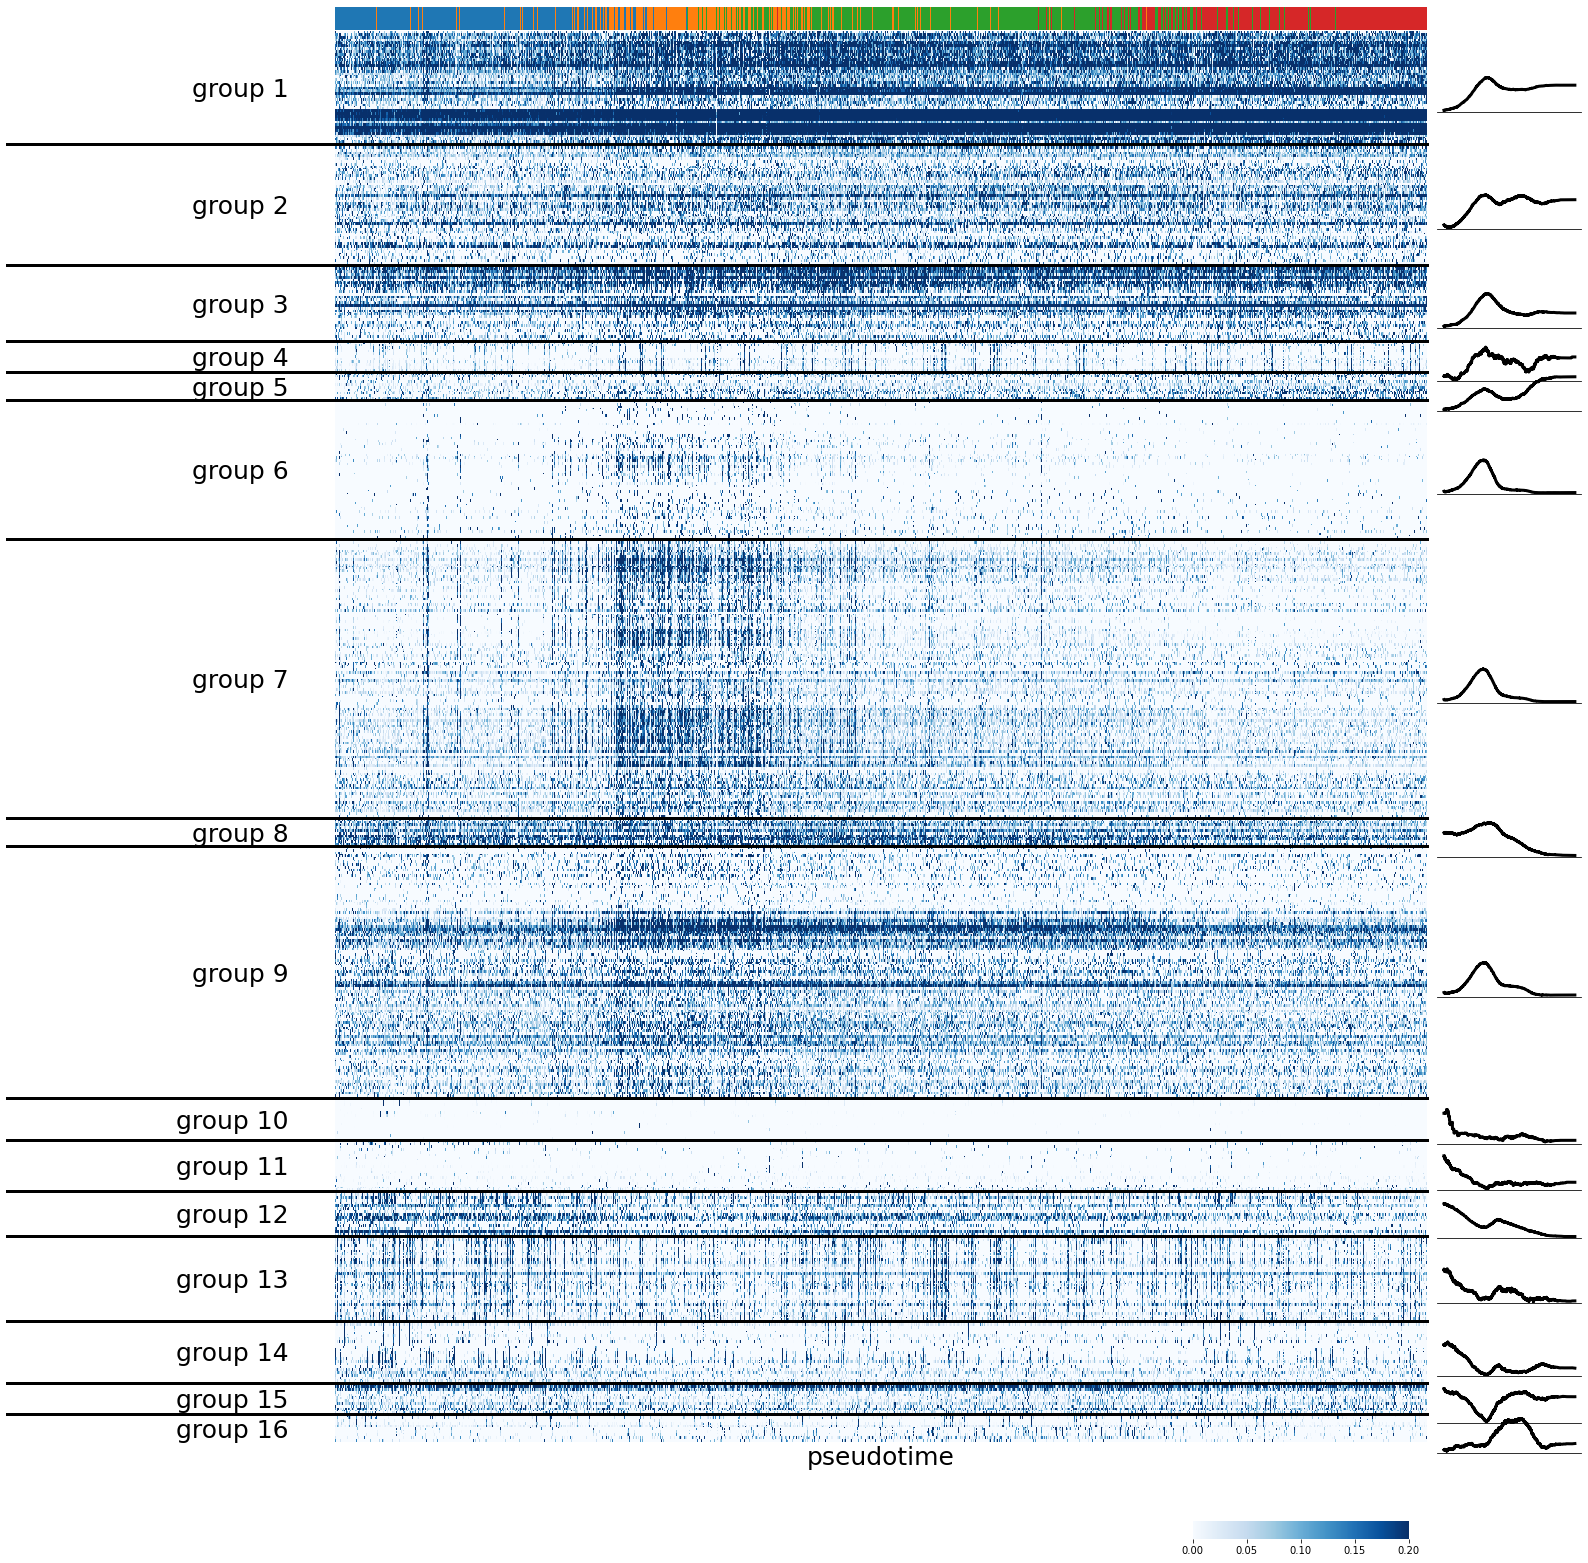

In [19]:
### add row colors so ax_row_colors is created
row_colors = ["#ffffff"]*len(clusters)

### create heatmap
fig = sns.clustermap(expression_genes.reset_index(drop=True), row_linkage=row_linkage, 
                     col_cluster=False, method="ward", figsize=(20, 25),
                     cmap="Blues",yticklabels=False,xticklabels=False,
                     cbar_kws={"orientation": "horizontal"}, row_colors=row_colors, 
                     vmax=0.2)

### change position of colorbar
fig.cax.set_position([0.83, -0.04, .15, .01])

### remove dendrogram
fig.ax_row_dendrogram.set_visible(False)

### add x axis label
fig.ax_heatmap.set_xlabel("pseudotime", fontsize=25)

### add black lines
cluster_sizes = clusters.value_counts().sort_index()
size=0
for i in cluster_sizes.index[0:len(cluster_sizes)-1]:
    size+=cluster_sizes[i]
    fig.ax_heatmap.axhline(size,color='black',ls='-', xmin=-.3, xmax=1, clip_on = False, linewidth=3)

### add patterns on right side
size=0
bottom_heatmap = np.array(fig.ax_heatmap.get_position())[0][1]
top_heatmap = np.array(fig.ax_heatmap.get_position())[1][1]
total_length = top_heatmap-bottom_heatmap
length_per_gene = total_length/len(response_genes)    
for i in cluster_sizes.index:
    size+=cluster_sizes[i]
    position=top_heatmap-(size*length_per_gene)-bottom_heatmap+(cluster_sizes[i]/2*length_per_gene)
    axs2 = fig.fig.add_axes([1,position,0.1,0.02])
    #axs2.plot(expression_genes.loc[response_genes[clusters==i]].mean(axis=0).rolling(10).sum(), linewidth=3, color=lut[np.unique(clusters)[i-1]])
    axs2.plot(expression_genes.loc[response_genes[clusters==i]].mean(axis=0).rolling(1000).sum(), linewidth=3, color="black")
    axs2.spines['top'].set_visible(False)
    axs2.spines['right'].set_visible(False)
    axs2.spines['left'].set_visible(False)
    axs2.get_xaxis().set_ticks([])
    axs2.get_yaxis().set_ticks([])
    axs2.patch.set_alpha(0)
    #axs2.axis('off')
    
### add pattern number for each cluster
net_ind = (cluster_sizes.cumsum()-(cluster_sizes/2))
net_names = ["group " + str(i) for i in range(1, len(cluster_sizes)+1)]
#net_names[9] = ""
#net_names[12] = ""
#net_names[16] = ""
fig.ax_row_colors.set_yticks(net_ind)
fig.ax_row_colors.set_yticklabels(net_names, fontdict=dict(color="black",size=25))
fig.ax_row_colors.yaxis.set_tick_params(size=0)

### add bar for distribution of experimental time
code=pd.factorize(adata.obs["time"][adata.obs["pseudotime"].sort_values().index])[0]
time_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cmap = colors.ListedColormap(time_colors)
fig.ax_col_dendrogram.imshow(code.reshape(1, -1), 
                             cmap=cmap, aspect='auto',
                             interpolation='nearest')

### decrease size of ax above the heatmap
hm = fig.ax_col_dendrogram.get_position()
fig.ax_col_dendrogram.set_position([hm.x0, hm.y0, hm.width, hm.height/15])

### save figure
save_path = "../figures/3.3.heatmap_patterns_response_genes_not_averaged.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)
    
plt.show()